#Neural Network from numpy

Vysotsky S. for 1514 school Yandex Lyceum, Yandex Education


In [1]:
!pip install graphviz

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [24]:
# f * (a * b + c)

def func(a=2, b=-3, c=10, f=-2):
    d = a * b
    e = d + c
    L = e * f
    return L

In [25]:
h = 0.0000001

(func(2 + h) - func()) / h

5.999999999062311

In [26]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        # self.label = f'{data=}'.split('=')[0]
        self.grad = 0

        self.backward = lambda: None


    def __repr__(self):
        return f"Value: {self.data}"


    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children=(self, other), _op="*")

        def backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out.backward = backward
        return out


    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out.backward = backward

        return out


    def __radd__(self, other):
        return self * other


    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op="+")

        def backward():
            self.grad += out.grad
            other.grad += out.grad

        out.backward = backward
        return out


    def __radd__(self, other):
        return self + other


    def __neg__(self):
        return self * -1


    def tanh(self):
        x = self.data
        val = (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)
        out = Value(val, _children=(self,), _op="tanh")

        def backward():
            self.grad += (1 - val**2) * out.grad

        out.backward = backward
        return out


    def full_backward(self):
        topo = []
        visited = set()

        def build_topo(v):
              if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node.backward()

In [27]:
a = Value(2, label="a")
b = Value(-3, label="b")
c = Value(10, label="c")
f = Value(-2, label="f")

d = a * b
d.label = "d"
e = d + c
e.label = "e"
L = e * f
L.label = "L"
L

Value: -8

In [28]:
L.full_backward()

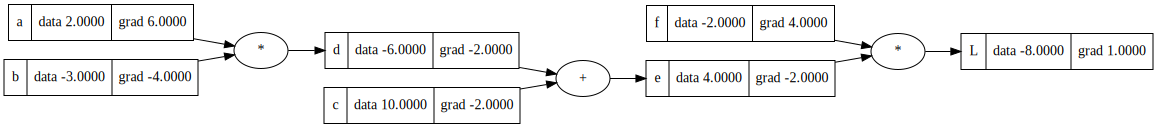

In [29]:
draw_dot(L)

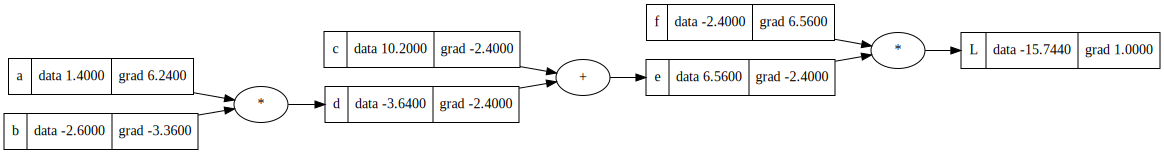

In [30]:
a = Value(2 - 0.1 * a.grad, label="a")
b = Value(-3 - 0.1 * b.grad, label="b")
c = Value(10 - 0.1 * c.grad, label="c")
f = Value(-2 - 0.1 * f.grad, label="f")

d = a * b
d.label = "d"
e = d + c
e.label = "e"
L = e * f
L.label = "L"

L.full_backward()
draw_dot(L)

In [11]:
# L.grad = 1
# f.grad = e.data #dL/df = e = dL/dL * dL/df
# e.grad = f.data
# c.grad = e.data
# d.grad = e.data
# b.grad = d.grad * a.data
# a.grad = d.grad * b.data

# #dL/dc = dL/de * de/dc
# #dL/dd = dL/de * de/dd

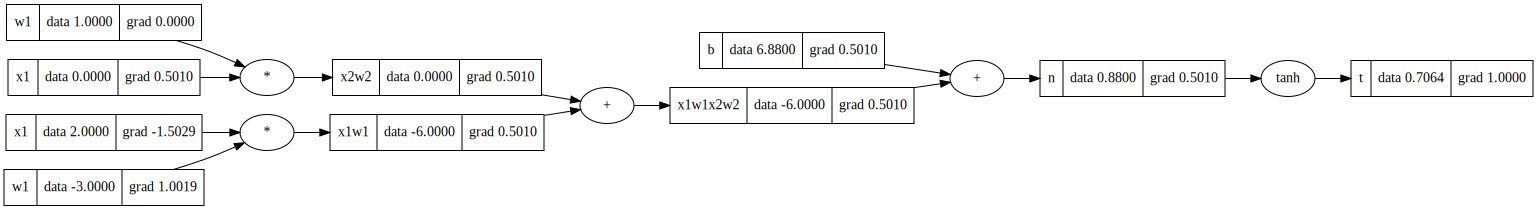

In [31]:
x1 = Value(2, label="x1")
x2 = Value(0, label="x1")

w1 = Value(-3, label="w1")
w2 = Value(1, label="w1")

b = Value(6.88, label="b")


x1w1 = x1 * w1
x1w1.label = 'x1w1'

x2w2 = x2 * w2
x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1x2w2"

n = x1w1x2w2 + b
n.label = "n"

t = n.tanh()
t.label = "t"

t.full_backward()
draw_dot(t)

In [32]:
import random


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))


    def __call__(self, x):
        act = sum([wi * xi for (wi, xi) in zip(self.w, x)] + [self.b])
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for ell in self.layers:
            x = ell(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [33]:
nn = MLP(3, [4, 4, 1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1, -1, -1, 1]
out = nn(xs[0])
out

Value: -0.27869689860265473

In [37]:
for epoch in range(20):
    ypreds = [nn(x) for x in xs]
    loss = sum((yout + (-ygt))**2 for (yout, ygt) in zip(ypreds, ys))

    for p in nn.parameters():
        p.grad = 0

    loss.full_backward()

    for p in nn.parameters():
        p.data -= 0.1 * p.grad

    print(loss)

Value: 0.016176909568533782
Value: 0.015272379100718436
Value: 0.01446168799742388
Value: 0.013731088750223453
Value: 0.013069377397087955
Value: 0.012467333974141594
Value: 0.011917303944539184
Value: 0.01141288094391962
Value: 0.010948663415591794
Value: 0.010520065860838918
Value: 0.010123170957767089
Value: 0.009754612611061666
Value: 0.009411482658295644
Value: 0.0090912558460766
Value: 0.008791729044119737
Value: 0.008510971649114803
Value: 0.008247284852426326
Value: 0.007999167981202353
Value: 0.0077652905233939855
Value: 0.007544468750025979


In [39]:
n = Neuron(3)
out = n([1, 2, 3])
out

Value: 0.999804243833885

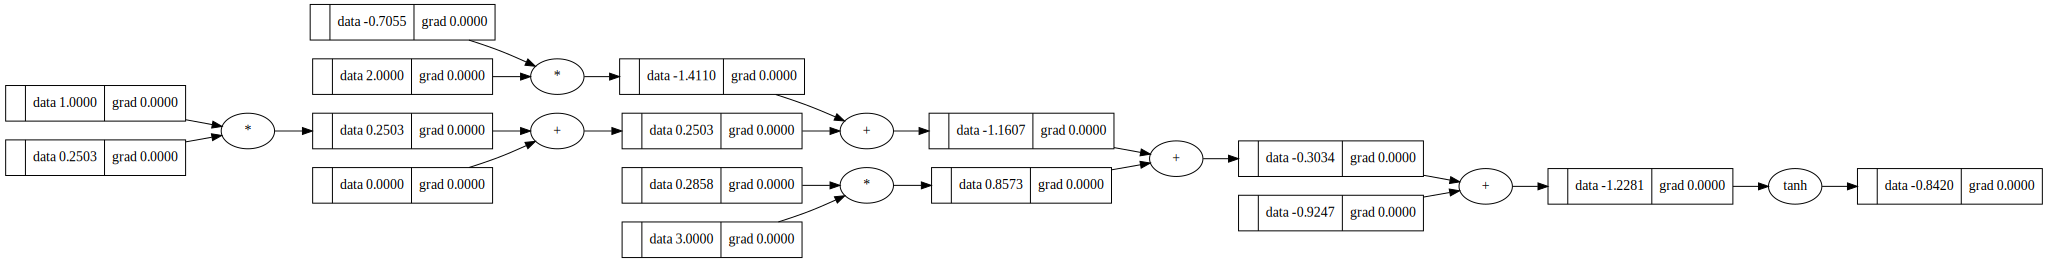

In [38]:
draw_dot(out)